In [ ]:
from google.colab import drive
drive_root = '/content/drive'
drive.mount(drive_root, force_remount=True)

Mounted at /content/drive


In [ ]:
import sys
import os

project_root = os.path.join(drive_root, 'MyDrive/Colab Notebooks/cmpe540/final-project')
source_root = os.path.join(project_root, 'src')
sys.path.append(source_root)
data_folder_path = os.path.join(project_root, 'data')
raw_data_folder_path = os.path.join(data_folder_path, 'raw')
processed_data_folder_path = os.path.join(data_folder_path, 'processed')
# train_data_path = os.path.join(processed_data_folder_path, "train_data.csv")

In [ ]:
import pandas as pd
import numpy as np

np.random.seed(42)

# Paths for model data
model_data_path = os.path.join(processed_data_folder_path, "model_data")
ndo_matrix_path = os.path.join(output_dir, "days_to_departure_matrix.npy")

# Read the data, carry out final changes
departure_date_series = pd.read_csv("lstm_data/departure_date_series.csv", index_col=0, parse_dates=True).squeeze("columns")
days_to_departure_matrix = np.load("lstm_data/days_to_departure_matrix.npy")
# full_set = pd.read_csv(train_data_path)
# full_set = full_set.drop(['flightDate'], axis=1)
full_set['isNonStop'] = full_set['isNonStop'].astype(int)

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset

# Define the dataset
class TicketPriceDataset(Dataset):
    def __init__(self, X, y):
      self.X = torch.tensor(X, dtype=torch.float32)
      self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
      return len(self.X)

    def __getitem__(self, idx):
      return self.X[idx], self.y[idx]

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# Define the model
class TicketPriceModel(nn.Module):
    def __init__(self):
      super(TicketPriceModel, self).__init__()
      # 3-layer LSTM block
      self.lstm = nn.LSTM(input_size=36, hidden_size=64, num_layers=3, batch_first=True)

      # 3-layer 1D Conv block
      self.conv1 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
      self.conv2 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
      self.conv3 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, padding=1)

      # Fully connected layers
      # Calculate the input size dynamically based on the output of the convolutional layers
      self.fc1_input_size = self._get_fc1_input_size(torch.randn(1, 36))  # Pass a dummy input to calculate size
      self.fc1 = nn.Linear(self.fc1_input_size, 128)
      self.fc2 = nn.Linear(128, 1)  # Output: ticket price

      # Activation function
      self.relu = nn.ReLU()

    def _get_fc1_input_size(self, x):
      """Calculates the input size for fc1 based on a dummy input."""
      x, _ = self.lstm(x)
      if x.dim() == 2:
        x = x.unsqueeze(1)
      x = x.permute(0, 2, 1)
      x = self.conv1(x)
      x = F.relu(x)
      x = self.conv2(x)
      x = F.relu(x)
      x = self.conv3(x)
      x = F.relu(x)
      return x.view(x.size(0), -1).shape[1]

    def forward(self, x):
      # LSTM block
      x, _ = self.lstm(x)

      # Check if x has 3 dimensions, if not, add a dimension
      if x.dim() == 2:  # If x has only 2 dimensions
        x = x.unsqueeze(1)  # Add a dimension at position 1

      # Permute for Conv1D: (batch_size, channels=64, seq_length)
      x = x.permute(0, 2, 1)

      # Pass through Conv layers
      x = self.conv1(x)  # -> (batch_size, 32, seq_length')
      x = F.relu(x)
      x = self.conv2(x)  # -> (batch_size, 16, seq_length'')
      x = F.relu(x)
      x = self.conv3(x)  # -> (batch_size, 16, seq_length''')
      x = F.relu(x)


      # Flatten for fully connected layers
      x = x.view(x.size(0), -1)  # (batch_size, 64 * 16)

      # Fully-connected layers
      x = self.fc1(x)
      x = F.relu(x)
      x = self.fc2(x)  # -> (batch_size, 1)

      return x


In [ ]:
from tqdm import tqdm
import time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt



# Training flow
def train_model(model, dataloader, optimizer, loss_fn, num_epochs, device, results_dir): # Add device parameter
    # File paths for saving loss data
    epoch_loss_file = os.path.join(results_dir, "epoch_losses.txt")
    epoch_losses = []
    val_losses = []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
      start_time = time.time()
      epoch_loss = 0.0

      model.train()
      for batch_idx, (inputs, targets) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}", leave=False)):
        # Move data to device
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = loss_fn(outputs.squeeze(), targets)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update parameters

        epoch_loss += loss.item()

      # Epoch summary metrics
      current_lr = optimizer.param_groups[0]['lr']
      epoch_duration = time.time() - start_time
      epoch_loss /= len(dataloader)
      epoch_losses.append(epoch_loss)

      # Validation loop
      model.eval()
      with torch.no_grad():
          val_loss = 0.0
          for inputs, targets in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} (Validation)", leave=False):
              inputs, targets = inputs.to(device), targets.to(device)
              outputs = model(inputs)
              loss = loss_fn(outputs.squeeze(), targets)
              val_loss += loss.item()

          val_loss /= len(val_loader)
          val_losses.append(val_loss)

          if val_loss < best_val_loss:
              best_val_loss = val_loss
              model_save_path = os.path.join(results_dir, 'best_model.pth')
              torch.save(model.state_dict(), model_save_path)
              print(f"Best model saved to: {model_save_path}")

      current_lr = optimizer.param_groups[0]['lr']
      epoch_duration = time.time() - start_time

      print(f"Epoch {epoch + 1}/{num_epochs}, Learning Rate: {current_lr}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}")

      with open(epoch_loss_file, "a") as f:
        # Save epoch summary
        epoch_summary = (
            f"Epoch [{epoch + 1}/{num_epochs}] completed in {str(timedelta(seconds=int(epoch_duration)))}\n"
            f"Learning Rate: {current_lr}\n"
            f"Average Training Loss: {epoch_loss:.4f}\n"
            f"Average Validation Loss: {val_loss:.4f}\n"
        )
        print(epoch_summary.strip())
        f.write(epoch_summary)

    # Save final model
    model_save_path = os.path.join(results_dir, 'final_trained_model.pth')
    torch.save(model.state_dict(), model_save_path)
    print(f"Final trained model saved to: {model_save_path}")

    # Save and display the training/validation loss plot
    plot_filename_drive = os.path.join(results_dir, 'training_validation_loss_plot.png')
    plt.figure()
    plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', label="Training Loss")
    plt.plot(range(1, num_epochs + 1), val_losses, marker='x', label="Validation Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()  # Add legend
    plt.grid(True)
    plt.savefig(plot_filename_drive)
    print(f"Training/Validation loss plot saved to: {plot_filename_drive}")
    plt.show()


In [ ]:
# Remove data of dates with instance count < 30
unq_ndo_counts = full_set.groupby(['NDepartureDate'])['ndo'].nunique()
dates_to_remove = unq_ndo_counts[unq_ndo_counts < 30].reset_index()['NDepartureDate'].tolist()
full_set = full_set[~full_set['NDepartureDate'].isin(dates_to_remove)]

In [ ]:
# Split training and test set (last 30 instances for test set)
max_date = full_set['NDepartureDate'].max()
train_set = full_set[full_set['NDepartureDate'] < max_date]

# Save test set to use in evaluation
test_set = full_set[full_set['NDepartureDate'] == max_date]
test_set.to_csv(os.path.join(results_dir, "test_data.csv"), index=False)

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

batch_size = 256


# Splitting with 80% for training and 20% for validation
X_train, X_val, y_train, y_val = train_test_split(
    train_set.drop(columns=['baseFare']).values, train_set['baseFare'].values, test_size=0.2, shuffle=False
)

# Dataloaders for training, validation and test
train_loader = DataLoader(
    TicketPriceDataset(X_train, y_train),
    batch_size=batch_size,
    shuffle=False
)

val_loader = DataLoader(
    TicketPriceDataset(X_val, y_val),
    batch_size=int(batch_size/4),
    shuffle=False
)

In [ ]:
import torch.optim as optim

# Hyperparameters
learning_rate = 0.00002
num_epochs = 50

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model, optimizer, and loss function
model = TicketPriceModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

In [ ]:
from datetime import datetime
import os

## Artifact paths (checkpoints, plots, metrics)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_dir = os.path.join(project_root, 'results', timestamp)

# Ensure artifact paths exist
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    print(f'Directory created at {results_dir}')
else:
  print(f'Directory {results_dir} already exists.')

Directory created at /content/drive/MyDrive/Colab Notebooks/cmpe540/final-project/results/20250113_191030


Best model saved to: /content/drive/MyDrive/Colab Notebooks/cmpe540/final-project/results/20250113_191030/best_model.pth
Epoch 1/50, Learning Rate: 2e-05, Training Loss: 135436.0867, Validation Loss: 93894.3919
Epoch [1/50] completed in 0:00:03
Learning Rate: 2e-05
Average Training Loss: 135436.0867
Average Validation Loss: 93894.3919


Best model saved to: /content/drive/MyDrive/Colab Notebooks/cmpe540/final-project/results/20250113_191030/best_model.pth
Epoch 2/50, Learning Rate: 2e-05, Training Loss: 135252.5104, Validation Loss: 93619.2741
Epoch [2/50] completed in 0:00:03
Learning Rate: 2e-05
Average Training Loss: 135252.5104
Average Validation Loss: 93619.2741


Best model saved to: /content/drive/MyDrive/Colab Notebooks/cmpe540/final-project/results/20250113_191030/best_model.pth
Epoch 3/50, Learning Rate: 2e-05, Training Loss: 134521.0216, Validation Loss: 92622.5400
Epoch [3/50] completed in 0:00:02
Learning Rate: 2e-05
Average Training Loss: 134521.0216
Average Validation Loss: 92622.5400


Best model saved to: /content/drive/MyDrive/Colab Notebooks/cmpe540/final-project/results/20250113_191030/best_model.pth
Epoch 4/50, Learning Rate: 2e-05, Training Loss: 132277.5035, Validation Loss: 89888.5585
Epoch [4/50] completed in 0:00:03
Learning Rate: 2e-05
Average Training Loss: 132277.5035
Average Validation Loss: 89888.5585


Best model saved to: /content/drive/MyDrive/Colab Notebooks/cmpe540/final-project/results/20250113_191030/best_model.pth
Epoch 5/50, Learning Rate: 2e-05, Training Loss: 126948.7691, Validation Loss: 84060.8718
Epoch [5/50] completed in 0:00:03
Learning Rate: 2e-05
Average Training Loss: 126948.7691
Average Validation Loss: 84060.8718


Best model saved to: /content/drive/MyDrive/Colab Notebooks/cmpe540/final-project/results/20250113_191030/best_model.pth
Epoch 6/50, Learning Rate: 2e-05, Training Loss: 116805.9415, Validation Loss: 74039.2169
Epoch [6/50] completed in 0:00:03
Learning Rate: 2e-05
Average Training Loss: 116805.9415
Average Validation Loss: 74039.2169


Best model saved to: /content/drive/MyDrive/Colab Notebooks/cmpe540/final-project/results/20250113_191030/best_model.pth
Epoch 7/50, Learning Rate: 2e-05, Training Loss: 100816.3564, Validation Loss: 59907.2472
Epoch [7/50] completed in 0:00:03
Learning Rate: 2e-05
Average Training Loss: 100816.3564
Average Validation Loss: 59907.2472


Best model saved to: /content/drive/MyDrive/Colab Notebooks/cmpe540/final-project/results/20250113_191030/best_model.pth
Epoch 8/50, Learning Rate: 2e-05, Training Loss: 79789.8514, Validation Loss: 43802.3108
Epoch [8/50] completed in 0:00:02
Learning Rate: 2e-05
Average Training Loss: 79789.8514
Average Validation Loss: 43802.3108


Best model saved to: /content/drive/MyDrive/Colab Notebooks/cmpe540/final-project/results/20250113_191030/best_model.pth
Epoch 9/50, Learning Rate: 2e-05, Training Loss: 56967.4755, Validation Loss: 29686.1742
Epoch [9/50] completed in 0:00:02
Learning Rate: 2e-05
Average Training Loss: 56967.4755
Average Validation Loss: 29686.1742


Best model saved to: /content/drive/MyDrive/Colab Notebooks/cmpe540/final-project/results/20250113_191030/best_model.pth
Epoch 10/50, Learning Rate: 2e-05, Training Loss: 37328.5360, Validation Loss: 21617.0210
Epoch [10/50] completed in 0:00:03
Learning Rate: 2e-05
Average Training Loss: 37328.5360
Average Validation Loss: 21617.0210


Best model saved to: /content/drive/MyDrive/Colab Notebooks/cmpe540/final-project/results/20250113_191030/best_model.pth
Epoch 11/50, Learning Rate: 2e-05, Training Loss: 24885.3355, Validation Loss: 20070.0772
Epoch [11/50] completed in 0:00:03
Learning Rate: 2e-05
Average Training Loss: 24885.3355
Average Validation Loss: 20070.0772


Epoch 12/50, Learning Rate: 2e-05, Training Loss: 19460.2692, Validation Loss: 21515.4788
Epoch [12/50] completed in 0:00:03
Learning Rate: 2e-05
Average Training Loss: 19460.2692
Average Validation Loss: 21515.4788


Epoch 13/50, Learning Rate: 2e-05, Training Loss: 17838.2071, Validation Loss: 22795.2777
Epoch [13/50] completed in 0:00:03
Learning Rate: 2e-05
Average Training Loss: 17838.2071
Average Validation Loss: 22795.2777


Epoch 14/50, Learning Rate: 2e-05, Training Loss: 17449.3043, Validation Loss: 23329.7619
Epoch [14/50] completed in 0:00:03
Learning Rate: 2e-05
Average Training Loss: 17449.3043
Average Validation Loss: 23329.7619


Epoch 15/50, Learning Rate: 2e-05, Training Loss: 17355.5577, Validation Loss: 23480.9915
Epoch [15/50] completed in 0:00:03
Learning Rate: 2e-05
Average Training Loss: 17355.5577
Average Validation Loss: 23480.9915


Epoch 16/50, Learning Rate: 2e-05, Training Loss: 17330.8240, Validation Loss: 23505.8739
Epoch [16/50] completed in 0:00:03
Learning Rate: 2e-05
Average Training Loss: 17330.8240
Average Validation Loss: 23505.8739


Epoch 17/50, Learning Rate: 2e-05, Training Loss: 17324.4294, Validation Loss: 23494.8627
Epoch [17/50] completed in 0:00:03
Learning Rate: 2e-05
Average Training Loss: 17324.4294
Average Validation Loss: 23494.8627


Epoch 18/50, Learning Rate: 2e-05, Training Loss: 17322.6110, Validation Loss: 23481.4633
Epoch [18/50] completed in 0:00:03
Learning Rate: 2e-05
Average Training Loss: 17322.6110
Average Validation Loss: 23481.4633


Epoch 19/50, Learning Rate: 2e-05, Training Loss: 17322.3646, Validation Loss: 23465.1147
Epoch [19/50] completed in 0:00:03
Learning Rate: 2e-05
Average Training Loss: 17322.3646
Average Validation Loss: 23465.1147


Epoch 20/50, Learning Rate: 2e-05, Training Loss: 17322.4230, Validation Loss: 23458.7792
Epoch [20/50] completed in 0:00:03
Learning Rate: 2e-05
Average Training Loss: 17322.4230
Average Validation Loss: 23458.7792


Epoch 21/50, Learning Rate: 2e-05, Training Loss: 17322.4432, Validation Loss: 23454.3741
Epoch [21/50] completed in 0:00:03
Learning Rate: 2e-05
Average Training Loss: 17322.4432
Average Validation Loss: 23454.3741


Epoch 22/50, Learning Rate: 2e-05, Training Loss: 17322.3593, Validation Loss: 23447.4403
Epoch [22/50] completed in 0:00:03
Learning Rate: 2e-05
Average Training Loss: 17322.3593
Average Validation Loss: 23447.4403


Epoch 23/50, Learning Rate: 2e-05, Training Loss: 17322.1812, Validation Loss: 23445.2440
Epoch [23/50] completed in 0:00:03
Learning Rate: 2e-05
Average Training Loss: 17322.1812
Average Validation Loss: 23445.2440


Epoch 24/50, Learning Rate: 2e-05, Training Loss: 17321.9150, Validation Loss: 23443.9390
Epoch [24/50] completed in 0:00:03
Learning Rate: 2e-05
Average Training Loss: 17321.9150
Average Validation Loss: 23443.9390


Epoch 25/50, Learning Rate: 2e-05, Training Loss: 17321.8148, Validation Loss: 23443.1989
Epoch [25/50] completed in 0:00:03
Learning Rate: 2e-05
Average Training Loss: 17321.8148
Average Validation Loss: 23443.1989


Epoch 26/50, Learning Rate: 2e-05, Training Loss: 17321.7813, Validation Loss: 23442.6580
Epoch [26/50] completed in 0:00:03
Learning Rate: 2e-05
Average Training Loss: 17321.7813
Average Validation Loss: 23442.6580


Epoch 27/50, Learning Rate: 2e-05, Training Loss: 17321.7349, Validation Loss: 23442.0801
Epoch [27/50] completed in 0:00:03
Learning Rate: 2e-05
Average Training Loss: 17321.7349
Average Validation Loss: 23442.0801


Epoch 28/50, Learning Rate: 2e-05, Training Loss: 17321.4402, Validation Loss: 23441.7829
Epoch [28/50] completed in 0:00:03
Learning Rate: 2e-05
Average Training Loss: 17321.4402
Average Validation Loss: 23441.7829


Epoch 29/50, Learning Rate: 2e-05, Training Loss: 17321.3415, Validation Loss: 23441.1588
Epoch [29/50] completed in 0:00:02
Learning Rate: 2e-05
Average Training Loss: 17321.3415
Average Validation Loss: 23441.1588


Epoch 30/50, Learning Rate: 2e-05, Training Loss: 17321.2285, Validation Loss: 23440.0420
Epoch [30/50] completed in 0:00:03
Learning Rate: 2e-05
Average Training Loss: 17321.2285
Average Validation Loss: 23440.0420


Epoch 31/50, Learning Rate: 2e-05, Training Loss: 17321.0969, Validation Loss: 23439.9788
Epoch [31/50] completed in 0:00:03
Learning Rate: 2e-05
Average Training Loss: 17321.0969
Average Validation Loss: 23439.9788


Epoch 32/50, Learning Rate: 2e-05, Training Loss: 17320.9942, Validation Loss: 23439.9013
Epoch [32/50] completed in 0:00:02
Learning Rate: 2e-05
Average Training Loss: 17320.9942
Average Validation Loss: 23439.9013


Epoch 33/50, Learning Rate: 2e-05, Training Loss: 17320.9261, Validation Loss: 23439.8579
Epoch [33/50] completed in 0:00:02
Learning Rate: 2e-05
Average Training Loss: 17320.9261
Average Validation Loss: 23439.8579


Epoch 34/50, Learning Rate: 2e-05, Training Loss: 17320.8190, Validation Loss: 23439.8100
Epoch [34/50] completed in 0:00:03
Learning Rate: 2e-05
Average Training Loss: 17320.8190
Average Validation Loss: 23439.8100


Epoch 35/50, Learning Rate: 2e-05, Training Loss: 17320.7729, Validation Loss: 23439.8145
Epoch [35/50] completed in 0:00:03
Learning Rate: 2e-05
Average Training Loss: 17320.7729
Average Validation Loss: 23439.8145


Epoch 36/50, Learning Rate: 2e-05, Training Loss: 17320.6512, Validation Loss: 23439.4505
Epoch [36/50] completed in 0:00:03
Learning Rate: 2e-05
Average Training Loss: 17320.6512
Average Validation Loss: 23439.4505


Epoch 37/50, Learning Rate: 2e-05, Training Loss: 17320.6579, Validation Loss: 23439.4375
Epoch [37/50] completed in 0:00:03
Learning Rate: 2e-05
Average Training Loss: 17320.6579
Average Validation Loss: 23439.4375


Epoch 38/50, Learning Rate: 2e-05, Training Loss: 17320.5794, Validation Loss: 23439.4167
Epoch [38/50] completed in 0:00:03
Learning Rate: 2e-05
Average Training Loss: 17320.5794
Average Validation Loss: 23439.4167


Epoch 39/50, Learning Rate: 2e-05, Training Loss: 17320.6588, Validation Loss: 23439.2877
Epoch [39/50] completed in 0:00:03
Learning Rate: 2e-05
Average Training Loss: 17320.6588
Average Validation Loss: 23439.2877


Epoch 40/50, Learning Rate: 2e-05, Training Loss: 17320.6927, Validation Loss: 23439.2795
Epoch [40/50] completed in 0:00:03
Learning Rate: 2e-05
Average Training Loss: 17320.6927
Average Validation Loss: 23439.2795


Epoch 41/50, Learning Rate: 2e-05, Training Loss: 17320.6979, Validation Loss: 23440.2665
Epoch [41/50] completed in 0:00:03
Learning Rate: 2e-05
Average Training Loss: 17320.6979
Average Validation Loss: 23440.2665


Epoch 42/50, Learning Rate: 2e-05, Training Loss: 17320.6604, Validation Loss: 23440.2751
Epoch [42/50] completed in 0:00:03
Learning Rate: 2e-05
Average Training Loss: 17320.6604
Average Validation Loss: 23440.2751


Epoch 43/50, Learning Rate: 2e-05, Training Loss: 17320.6076, Validation Loss: 23440.3397
Epoch [43/50] completed in 0:00:03
Learning Rate: 2e-05
Average Training Loss: 17320.6076
Average Validation Loss: 23440.3397


Epoch 44/50, Learning Rate: 2e-05, Training Loss: 17320.6576, Validation Loss: 23440.3651
Epoch [44/50] completed in 0:00:03
Learning Rate: 2e-05
Average Training Loss: 17320.6576
Average Validation Loss: 23440.3651


Epoch 45/50, Learning Rate: 2e-05, Training Loss: 17320.6471, Validation Loss: 23440.3478
Epoch [45/50] completed in 0:00:03
Learning Rate: 2e-05
Average Training Loss: 17320.6471
Average Validation Loss: 23440.3478


Epoch 46/50, Learning Rate: 2e-05, Training Loss: 17320.6229, Validation Loss: 23440.3701
Epoch [46/50] completed in 0:00:03
Learning Rate: 2e-05
Average Training Loss: 17320.6229
Average Validation Loss: 23440.3701


Epoch 47/50, Learning Rate: 2e-05, Training Loss: 17320.5948, Validation Loss: 23440.2451
Epoch [47/50] completed in 0:00:03
Learning Rate: 2e-05
Average Training Loss: 17320.5948
Average Validation Loss: 23440.2451


Epoch 48/50, Learning Rate: 2e-05, Training Loss: 17320.5700, Validation Loss: 23440.3093
Epoch [48/50] completed in 0:00:02
Learning Rate: 2e-05
Average Training Loss: 17320.5700
Average Validation Loss: 23440.3093


Epoch 49/50, Learning Rate: 2e-05, Training Loss: 17320.6021, Validation Loss: 23440.3659
Epoch [49/50] completed in 0:00:03
Learning Rate: 2e-05
Average Training Loss: 17320.6021
Average Validation Loss: 23440.3659


Epoch 50/50, Learning Rate: 2e-05, Training Loss: 17320.6142, Validation Loss: 23440.4554
Epoch [50/50] completed in 0:00:03
Learning Rate: 2e-05
Average Training Loss: 17320.6142
Average Validation Loss: 23440.4554
Final trained model saved to: /content/drive/MyDrive/Colab Notebooks/cmpe540/final-project/results/20250113_191030/final_trained_model.pth
Training/Validation loss plot saved to: /content/drive/MyDrive/Colab Notebooks/cmpe540/final-project/results/20250113_191030/training_validation_loss_plot.png


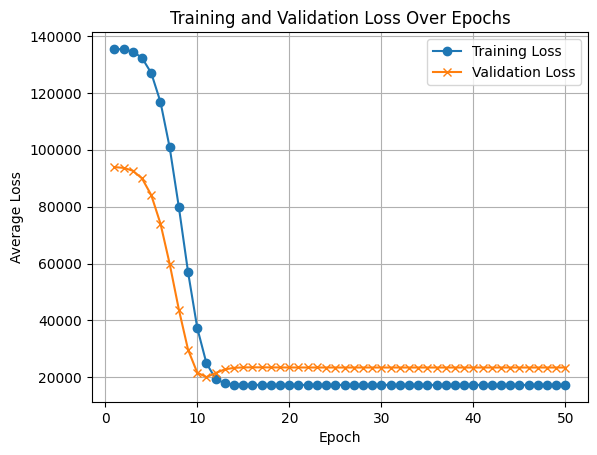

In [ ]:
# Train the model
train_model(model, train_loader, optimizer, loss_fn, num_epochs, device, results_dir)